In [1]:
%matplotlib inline

import os
import sys
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lmfit


In [2]:
filelist = sorted(glob.glob(os.path.join("/scratch/w85/cxa547/bam", "tcenvflow_serial.*.csv")))
df = pd.concat((pd.read_csv(f) for f in filelist), ignore_index=True)

In [3]:
def twolevel_model(alpha, xl, xu):
    return alpha*xl + (1-alpha)*xu

def fixed_model(xl, xu):
    return 0.8*xl + 0.2*xu

In [4]:
alpha = lmfit.Parameter('alpha', value=0.8, min=0, max=1)
p = lmfit.Parameters()
p.add(alpha)
rmod = lmfit.Model(twolevel_model, independent_vars=['xl', 'xu'])


In [5]:
fmod = lmfit.Model(fixed_model, independent_vars=['xl', 'xu'])

In [6]:
u = df['u'] # Observed u component
ul = df['u850'] # Low-level u component of environmental flow
uu = df['u250'] # Upper-level u component of environmental flow
v = df['v']
vl = df['v850']
vu = df['v250']

In [7]:
uresult = rmod.fit(u, p, xl=ul, xu=uu)
vresult = rmod.fit(v, p, xl=vl, xu=vu)

ufresult = fmod.fit(u, p, xl=ul, xu=uu)
vfresult = fmod.fit(v, p, xl=vl, xu=vu)


In [29]:
ua = uresult.params['alpha'].value
va = vresult.params['alpha'].value

(-15.0, 15.0)

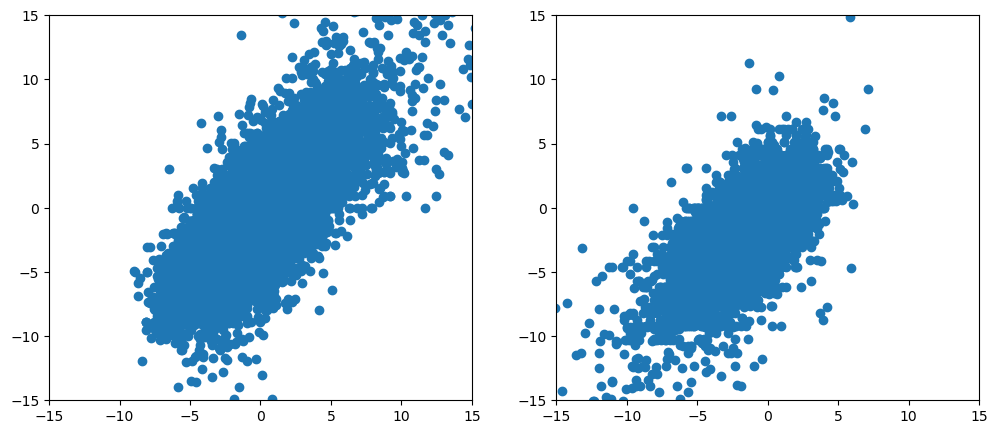

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(ua*ul + (1-ua)*uu, u, 'o')
ax[0].set_ylim((-15, 15))
ax[0].set_xlim((-15, 15))
ax[1].plot(va*vl + (1-va)*vu, v, 'o')
ax[1].set_ylim((-15, 15))
ax[1].set_xlim((-15, 15))

In [37]:
df['band'] = pd.cut(df['MAX_WIND_SPD'], np.arange(10, 71, 5), labels=np.arange(10, 70, 5))

In [ ]:
au = []
aust = []
ursq = []
ufrsq = []
av = []
avst = []
vrsq = []
vfrsq = []
for x in np.arange(10, 70, 5):
    ddf = df[df['band']==x]
    model = lmfit.Model(twolevel_model, independent_vars=['xl', 'xu'])
    u = ddf['u'] # Observed u component
    ul = ddf['u850'] # Low-level u component of environmental flow
    uu = ddf['u250'] # Upper-level u component of environmental flow
    v = ddf['v']
    vl = ddf['v850']
    vu = ddf['v250']
    uresult = rmod.fit(u, p, xl=ul, xu=uu)
    vresult = rmod.fit(v, p, xl=vl, xu=vu)
    ufresult = fmod.fit(u, p, xl=ul, xu=uu)
    vfresult = fmod.fit(v, p, xl=vl, xu=vu)

    au.append(uresult.params['alpha'].value)
    aust.append(uresult.params['alpha'].stderr)
    ursq.append(uresult.rsquared)
    ufrsq.append(ufresult.rsquared)
    av.append(vresult.params['alpha'].value)
    avst.append(vresult.params['alpha'].stderr)
    vrsq.append(vresult.rsquared)
    vfrsq.append(vfresult.rsquared)

au = np.array(au)
av = np.array(av)
aust = np.array(aust)
avst = np.array(avst)
ursq = np.array(ursq)
vrsq = np.array(vrsq)
ufrsq = np.array(ufrsq)
vfrsq = np.array(vfrsq)




Fit a simple linear regression to the resulting fits of $\alpha$ at different intensity. 

$\alpha(v) = m v + b$

In [ ]:
lm = lmfit.Parameter(name='m', value=.01, max=0)
lb = lmfit.Parameter(name='b', value=1, min=0)
lp = lmfit.Parameters()
lp.add(lm)
lp.add(lb)

def lin_model(m, b, x):
    return (m*x + b)

lmod = lmfit.Model(lin_model, independent_vars=['x'])
lresult = lmod.fit((au+av)/2, lp, x=np.arange(10, 70, 5))
print(lresult.rsquared)

Now fit the linear $\alpha(v)$ to wind speeds of 50 m/s or less. There are fewer records with maximum wind speed $\ge$ 50 m/s

In [39]:
l2result = lmod.fit((au[:-3]+av[:-3])/2, lp, x=np.arange(10, 55, 5))
print(l2result.rsquared)

0.9211535254369623


In [40]:
print(l2result.best_fit.max(), l2result.best_fit.min())

0.7579196052583625 0.5832195198630685


In [41]:
lresult

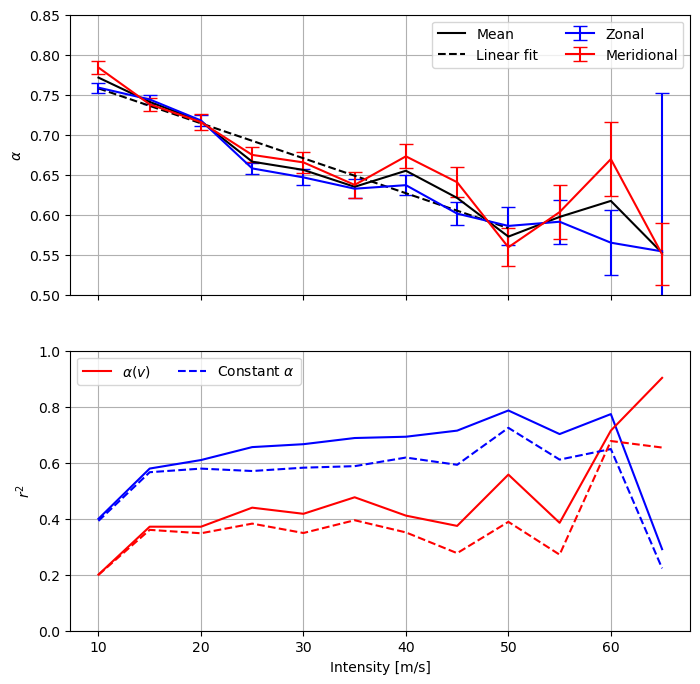

In [44]:
x = np.arange(10, 70, 5)

fig, axes = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
axes[0].errorbar(x, au, yerr=aust, color='b', capsize=5, label='Zonal')
axes[0].errorbar(x, av, yerr=avst, color='r', capsize=5, label='Meridional')
axes[0].plot(x, (au+av)/2., color='k', label="Mean")
axes[0].plot(x[:-3], l2result.best_fit, color='k', linestyle='--', label="Linear fit")
axes[0].grid(True)
axes[0].set_ylim((0.5, 0.85))
axes[0].set_ylabel(r"$\alpha$")
axes[0].legend(ncols=2)

axes[1].plot(x, ursq, color='b')
axes[1].plot(x, vrsq, color='r', label=r"$\alpha (v)$")
axes[1].plot(x, ufrsq, color='b', linestyle='--', label=r"Constant $\alpha$")
axes[1].plot(x, vfrsq, color='r', linestyle='--')
axes[1].grid(True)
axes[1].set_ylim((0, 1))
axes[1].set_ylabel(r"$r^{2}$")
axes[1].set_xlabel("Intensity [m/s]")
axes[1].legend(ncols=2)
plt.show()
#plt.savefig("/scratch/w85/cxa547/envflow/tcenvflow_fit.png", bbox_inches='tight')

In [84]:
df.drop("Unnamed: 0", axis=1).to_csv("/scratch/w85/cxa547/envflow/tcenvflow.csv", index=False)